<a href="https://colab.research.google.com/github/21B031186/CompVision/blob/main/midterm_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1. Solve classification task

# First Second name PLEASE: Tugelbay Ansar


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. Data preparation

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('beans', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteRVG2SF/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteRVG2SF/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteRVG2SF/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
df = tfds.as_dataframe(ds)

In [ ]:
df.head()

,image,label
0,"[[[129, 118, 88], [95, 81, 54], [84, 66, 46], ...",1
1,"[[[64, 88, 14], [65, 89, 15], [66, 88, 15], [6...",0
2,"[[[93, 109, 83], [96, 112, 86], [97, 115, 91],...",1
3,"[[[78, 103, 46], [86, 102, 53], [103, 103, 67]...",2
4,"[[[149, 123, 134], [117, 91, 102], [119, 88, 1...",1


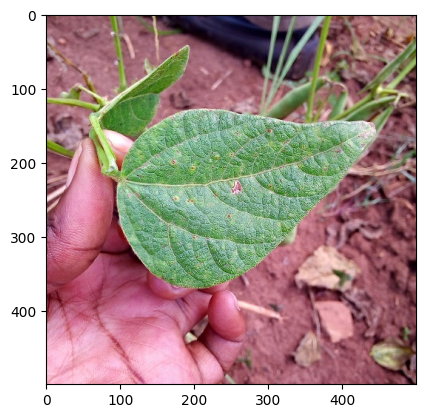

In [ ]:
plt.imshow(df['image'][0], cmap='gray')

750000
[1 0 2]


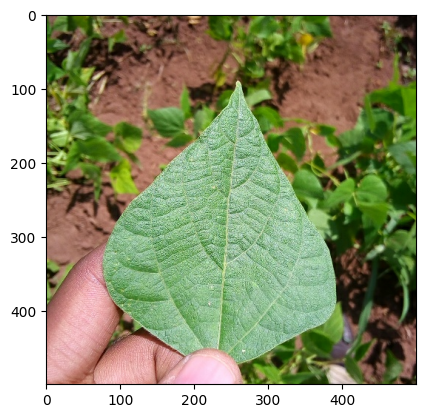

In [ ]:
plt.imshow(df['image'][3], cmap='gray')
print(df['image'][3].size)
unique_labels = df['label'].unique()
print(unique_labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(df['image']), np.array(df['label']), test_size=0.2, random_state=10)
print(X_train.size)

827


# **ALexNet**

**OWN** **MODEL**

In [ ]:
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [ ]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 122 * 122, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 122 * 122)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    net = MyConvNet().cuda()
else:
    net = MyConvNet()

batch = next(iter(trainloader))
input_data = batch[0].to(device)
print(input_data.shape)

net.forward(input_data)

torch.Size([4, 3, 500, 500])


tensor([[ 0.0958, -0.1305,  0.0398],
        [ 0.0932, -0.1292,  0.0401],
        [ 0.0945, -0.1304,  0.0394],
        [ 0.0959, -0.1288,  0.0400]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))

epoch  0  train_loss  0.9406878552287097  test_loss  0.7522177882492542
epoch  1  train_loss  0.7266328329769309  test_loss  0.739281567816551
epoch  2  train_loss  0.629915602253255  test_loss  0.6611681159299153
epoch  3  train_loss  0.5366560446035459  test_loss  0.6446095891296864
epoch  4  train_loss  0.4520920647515191  test_loss  0.652914800752814
epoch  5  train_loss  0.38403289649941497  test_loss  0.6790223756375221
epoch  6  train_loss  0.31374057149289597  test_loss  0.7440103720873594
epoch  7  train_loss  0.2655427030823081  test_loss  0.8319346110264842
epoch  8  train_loss  0.19828479965149926  test_loss  0.9445074337462966
epoch  9  train_loss  0.11364148340889833  test_loss  0.9028078282538515


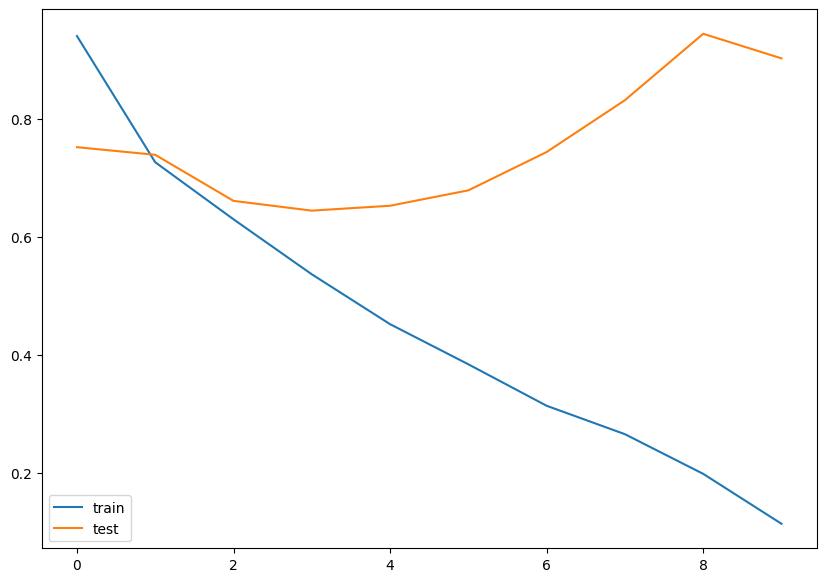

In [ ]:

plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [ ]:

# import torch
from sklearn.metrics import confusion_matrix, classification_report
# from torch.utils.data import DataLoader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # net.to(device)

net.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[51  9  6]
 [21 40 12]
 [ 8  0 60]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70        66
           1       0.82      0.55      0.66        73
           2       0.77      0.88      0.82        68

    accuracy                           0.73       207
   macro avg       0.74      0.73      0.73       207
weighted avg       0.74      0.73      0.72       207



In [ ]:
net.eval()
image = df['image'][12]
target_class = df['label'][12]
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)
input_image = input_image.to(device)
with torch.no_grad():
    output = net(input_image)


_, predicted_class = torch.max(output, 1)

print("Predicted class:", predicted_class.item())
probabilities = torch.nn.functional.softmax(output[0], dim=0)
max_prob, predicted_class = torch.max(probabilities, 0)

print("Target class:", target_class)
print("Max probability:", max_prob.item())
comparison = "Correct" if predicted_class == target_class else "Incorrect"
print(comparison)

Predicted class: 2
Target class: 2
Max probability: 0.8892484903335571
Correct


In [ ]:
def check_result(ind):
  net.eval()
  image = df['image'][ind]
  target_class = df['label'][ind]
  transform = transforms.Compose([
   transforms.ToTensor(),
  ])
  input_image = transform(image).unsqueeze(0)
  input_image = input_image.to(device)
  with torch.no_grad():
    output = net(input_image)


  _, predicted_class = torch.max(output, 1)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  comparison = "Correct" if predicted_class == target_class else "Incorrect"
  return predicted_class.item(), target_class,  max_prob.item(), comparison



In [ ]:
result = check_result(14)
print("Predicted class: ", result[0])
print("Target class: ", result[1])
print("Max probability: ", result[2])
print("Comparison: ", result[3])
# I create function that we give index of image from dataframe

Predicted class:  2
Target class:  2
Max probability:  0.8892484903335571
Comparison:  Correct


# With VGG Model


In [ ]:
import cv2
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
class BeansDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        image = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

train_ds = BeansDataset(X_train, y_train, transform=transform)
test_ds = BeansDataset(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
import torchvision.models as models

vgg_model = models.vgg16(pretrained=True)

num_classes = 3
vgg_model.classifier[-1] = nn.Linear(4096, num_classes)

for param in vgg_model.features.parameters():
    param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    vgg_model.train()

    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.4128
Epoch [2/10], Loss: 0.0905
Epoch [3/10], Loss: 0.2008
Epoch [4/10], Loss: 0.3350
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.2636
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 4.1766
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0000


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
vgg_model.eval()

with torch.no_grad():
    test = []
    pred = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg_model(images)
        _, predicted = torch.max(outputs.data, 1)

        test.extend(predicted.cpu().numpy())
        pred.extend(labels.cpu().numpy())

test = np.array(test)
pred = np.array(pred)

accuracy = np.sum(test == pred) / len(test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(test, pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(test, pred)
print("Classification Report:")
print(class_report)

Test Accuracy: 79.71%
Confusion Matrix:
[[41  4  0]
 [19 58  2]
 [ 6 11 66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        45
           1       0.79      0.73      0.76        79
           2       0.97      0.80      0.87        83

    accuracy                           0.80       207
   macro avg       0.80      0.81      0.79       207
weighted avg       0.83      0.80      0.80       207



Baseline accuracy more than 70 for all of classes AND more than 35 for each (7 points)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[41  4  0]
 [19 58  2]
 [ 6 11 66]]
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        45
           1       0.79      0.73      0.76        79
           2       0.97      0.80      0.87        83

    accuracy                           0.80       207
   macro avg       0.80      0.81      0.79       207
weighted avg       0.83      0.80      0.80       207



(3 points) Write a function for classification of one image:
<br> Input: 1 image from dataset
<br> Output: predicted class, target class and comparison

In [ ]:
#your code here
def classify_single_image(model, image, target_class):
    model.eval()

    with torch.no_grad():
        image = Image.fromarray(image)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        image = transform(image).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image = image.to(device)
        output = model(image)
        _, predicted_class = torch.max(output.data, 1)
        predicted_class = predicted_class.item()

        comparison = "Correct" if predicted_class == target_class else "Incorrect"

        return predicted_class, target_class, comparison

In [ ]:
result = classify_single_image(vgg_model,df['image'][3],df['label'][3])
print("Predicted Class:", result[0])
print("Target Class:", result[1])
print("Comparison:", result[2])

Predicted Class: 2
Target Class: 2
Comparison: Correct


Theoretical part:
<br>1)Describe your steps if you are using a dataset that does not have enough training data. (3p)
<br>2)Describe difference between BCE, MSE and Cross Entropy (2p)

In [ ]:
# 1) When dealing with a dataset lacking sufficient training data, assess the complexity of the problem to determine the required data size,
# plot a learning curve to gauge the dataset's adequacy, use data augmentation and synthesis techniques like scaling, cropping, rotation for images, SMOTE for imbalanced datasets,
# and GANs for generating new data points. Leverage transfer learning by starting with pre-trained models and fine-tuning them on your dataset. If possible,
# collect more data through domain experts or  open-source datasets. Create new features from the existing dataset to compensate for the lack of examples.
# These strategies can help mitigate the impact of insufficient training data, but the choice of strategy depends on the specifics of your problem and dataset.
# 2) BCE(Binary Cross Entropy), MSE(Mean Square Error) and Cross Entropy are diffrent types of loss functions used for diffrent purposes:
# Binary Cross-Entropy (BCE) is used for binary classification, measuring the difference between predicted probabilities and actual binary labels,
# with a heavier penalty for low prediction probabilities for the true class. Mean Squared Error (MSE) is used in regression tasks, calculating the
# average of squared differences between predicted and actual values, making it sensitive to outliers. Cross Entropy (CE) is used for classification problems,
# quantifying the difference between predicted probability distributions and actual class distributions, suitable for both binary and multi-class classification problems
